# Chapter 19 制約付き非線形最小二乗法

## 19.1 制約付き非線形最小二乗法

## 19.2 ペナルティalgorithm

本書アルゴリズム19.1のペナルティ法を実装しよう．

In [3]:
function penalty_method(f, Df, g, Dg, x1, lambda1; kmax = 100,
                        feas_tol = 1e-4, oc_tol = 1e-4)
x = x1
mu = 1.0
feas_res = [norm(g(x))]
oc_res = [norm(2*Df(x)'*f(x) + 2*mu*Dg(x)'*g(x))] 
lm_iters = zeros(Int64,0,1);
for k=1:kmax
  F(x) = [f(x); sqrt(mu)*g(x)]
  DF(x) = [Df(x); sqrt(mu)*Dg(x)]
  x, hist = levenberg_marquardt(F,DF,x,lambda1,tol=oc_tol)
  feas_res = [feas_res; norm(g(x))]
  oc_res = [oc_res; hist["residuals"][end]]
  lm_iters = [lm_iters; length(hist["residuals"])]
  if norm(g(x)) < feas_tol
    break
  end
  mu = 2*mu
end
return x, Dict([ ("lm_iterations", lm_iters),
                 ("feas_res", feas_res), ("oc_res", oc_res) ])
end

penalty_method (generic function with 1 method)

11行目では前章で使った関数`levenberg_marquardt`で$\| F(x) \|^2$を最小化している．ここで
$$
F(x) =
\begin{bmatrix}
f(x) \\
\sqrt{\mu} \ g(x)
\end{bmatrix}
$$
である．以下では2つの残差を評価する．　制約条件の残差$\| g(x^{(k)}) \|$は制約条件$g(x)=0$の誤差である．最適性条件残差の定義は
$$
\| 2D f(x^{(k)})^T f(x^{(k)}) + 2D g(x^{(k)})^T z^{(k)} \|
$$
である．ここで$z^{(k)} = 2\mu^{(k-1)} g(x^{(k)}$)である（ここでは$\mu^{(0)}=\mu^{(1)}$とする）．
13行目では最適性条件の残差を，Levenberg–Marquardt法の最終的な残差としている．20行目で返しているのは，最終的な$x$と，
Levenberg–Marquardt法の各呼び出しでの反復回数と，2つの残差の系列である．

### 例

以下の2変数問題にこの方法を適用する．
$$
f(x_1, x_2) = 
\begin{bmatrix}
x_1 + \exp(-x_2) \\
x_1^2 + 2 x_2 + 1
\end{bmatrix}, \quad
g(x_1, x_2) = x_1^2 + x_1^3 + x_2 + x_2^2
$$

In [4]:
using LinearAlgebra, VMLS, Plots

In [5]:
f(x) = [ x[1] + exp(-x[2]), x[1]^2 + 2*x[2] + 1 ];
Df(x) = [ 1.0 -exp(-x[2]);  2*x[1]  2 ];
g(x) = [ x[1] + x[1]^3 + x[2] + x[2]^2 ];
Dg(x) = [ 1 + 3*x[1]^2  1 + 2*x[2] ];
x, hist = penalty_method(f, Df, g, Dg, [0.5, -0.5], 1.0);
x

2-element Array{Float64,1}:
 -3.334955140841332e-5 
 -2.7682497163944097e-5

以下のコードはLevenberg–Marquardt法の累積反復回数に対する残差を階段状にプロットする．
結果は図19.1であり，本書の図19.4にもある．


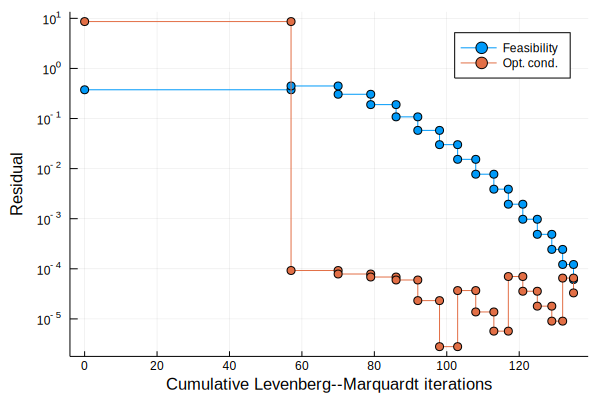

In [6]:
cum_lm_iters = cumsum(hist["lm_iterations"], dims=1);
itr = vcat([0], [[i; i] for i in cum_lm_iters]...);
feas_res = vcat([
                 [r;r] for r in hist["feas_res"][1:end-1]]...,
                 hist["feas_res"][end]);
oc_res = vcat([
               [r;r] for r in hist["oc_res"][1:end-1]]...,
                          hist["oc_res"][end]);
plot(itr, feas_res, shape=:circle, label = "Feasibility")
plot!(itr, oc_res, shape=:circle, label = "Opt. cond.")
plot!(yscale = :log10,
      xlabel = "Cumulative Levenberg--Marquardt iterations",
      ylabel = "Residual")

![図19.1](fig19-1.pdf)

図19.1 ペナルティ法におけるLevenberg-Marquardt法の累積反復回数に対する制約条件の残差と最適性条件の残差



## 19.3 拡張ラグランジュ法

以下は拡張ラグランジュ法のコードである．`VMLS`パッケージにも含まれている．


In [7]:
function aug_lag_method(f, Df, g, Dg, x1, lambda1; kmax = 100,
            feas_tol = 1e-4, oc_tol = 1e-4)
    x = x1
    z = zeros(length(g(x)))
    mu = 1.0
    feas_res = [norm(g(x))]
    oc_res = [norm(2*Df(x)'*f(x) + 2*mu*Dg(x)'*z)]
    lm_iters = zeros(Int64,0,1);
    for k=1:kmax
      F(x) = [f(x); sqrt(mu)*(g(x) + z/(2*mu))]
      DF(x) = [Df(x); sqrt(mu)*Dg(x)]
      x, hist = levenberg_marquardt(F, DF, x, lambda1, tol=oc_tol)
      z = z + 2*mu*g(x)
      feas_res = [feas_res; norm(g(x))]
      oc_res = [oc_res; hist["residuals"][end]]
      lm_iters = [lm_iters; length(hist["residuals"])]
      if norm(g(x)) < feas_tol
            break
        end
        mu = (norm(g(x)) < 0.25*feas_res[end-1]) ? mu : 2*mu
    end
    return x, z, Dict([ ("lm_iterations", lm_iters),
                        ("feas_res", feas_res), ("oc_res", oc_res)])
end

aug_lag_method (generic function with 1 method)

12行目で
Levenberg–Marquardt法を呼び出して，$\| F(x) \|^2$を最小化している．ここで
$$
F(x) =
\begin{bmatrix}
f(x) \\
\sqrt{\mu^{(k)}} \ (g(x) + z^{(k)} / (2 \mu^{(k)}))
\end{bmatrix}
$$
である．ここでも制約条件の残差$\| g(x^{(k)}) \|$と
最適性条件の残差
$$
\| 2D f(x^{(k)})^T f(x^{(k)}) + 2D g(x^{(k)})^T z^{(k)} \|
$$
を保持し，辞書として返す．


### 例

先程の小規模な例題を続けよう．

In [8]:
x, z, hist = aug_lag_method(f, Df, g, Dg, [0.5, -0.5], 1.0);

In [9]:
x

2-element Array{Float64,1}:
 -1.8646614856169702e-5
 -1.5008567819930016e-5

In [10]:
z

1-element Array{Float64,1}:
 -1.9999581273499105

以下のコードは本書の図19.4の収束の様子を表す（図19.2）．

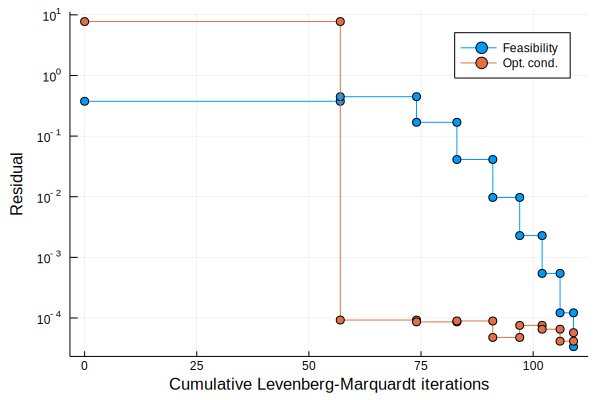

In [11]:
cum_lm_iters = cumsum(hist["lm_iterations"],dims=1);
itr = vcat([0], [[i; i] for i in cum_lm_iters]...);
feas_res = vcat([
           [r;r] for r in hist["feas_res"][1:end-1]]...,
           hist["feas_res"][end]);
oc_res = vcat([
           [r;r] for r in hist["oc_res"][1:end-1]]...,
           hist["oc_res"][end]);
plot(itr, feas_res, shape=:circle, label = "Feasibility")
plot!(itr, oc_res, shape=:circle, label = "Opt. cond.")
plot!(yscale = :log10,
       xlabel = "Cumulative Levenberg-Marquardt iterations",
       ylabel = "Residual")


![図19.2](fig19-2.pdf)

図19.2 拡張ラグランジュ法におけるLevenberg-Marquardt法の累積反復回数に対する制約条件の残差と最適性条件の残差


## 19.4 非線形制御
